In [2]:
import os
import logging
from pytorch_lightning.utilities.seed import seed_everything

from DLIP.utils.loading.initialize_wandb import initialize_wandb
from DLIP.utils.loading.load_data_module import load_data_module
from DLIP.utils.loading.load_model import load_model
from DLIP.utils.loading.load_transforms import load_transforms
from DLIP.utils.loading.merge_configs import merge_configs
from DLIP.utils.loading.prepare_directory_structure import prepare_directory_structure

from DLIP.utils.loading.split_parameters import split_parameters
from DLIP.utils.cross_validation.cv_trainer import CVTrainer

import matplotlib.pyplot as plt
import numpy as np


logging.basicConfig(level=logging.INFO)

config_files = "/home/ws/sc1357/projects/devel/src/self-supervised-biomedical-image-segmentation/DLIP/experiments/configurations/base_cfg/cfg_inst_seg_base.yaml"
ckpt_file = "/home/ws/sc1357/data/0556/dnn_weights.ckpt"

cfg_yaml = merge_configs(config_files)
experiment_name=cfg_yaml['experiment.name']['value']

config = initialize_wandb(
    cfg_yaml=cfg_yaml,
    experiment_dir=None,
    config_name=None,
    disabled=True
)

#seed_everything(seed=cfg_yaml['experiment.seed']['value'])
parameters_splitted = split_parameters(config, ["model", "train", "data"])

data = load_data_module(parameters_splitted["data"], do_val_init=False)
model = load_model(parameters_splitted["model"], checkpoint_path_str="/home/ws/sc1357/data/0556/dnn_weights.ckpt")



# data.labeled_train_dataset.raw_mode = True

# print(data.labeled_train_dataset.indices[0])

# plt.imshow(data.labeled_train_dataset[0]["image"])
# plt.show()

# data.labeled_train_dataset.raw_mode = False

# plt.imshow(data.labeled_train_dataset[0]["image"].permute(1,2,0).numpy())
# plt.show()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
INFO:root:Using 12 workers for data loading
INFO:root:Length of labeled train dataset: 592
INFO:root:Length of unlabeled train dataset: 0


[06/28 09:17:46 detectron2]: Rank of current process: 0. World size: 1
[06/28 09:17:47 detectron2]: Environment info:
----------------------  ---------------------------------------------------------------------------------------
sys.platform            linux
Python                  3.8.5 (default, Sep  4 2020, 07:30:14) [GCC 7.3.0]
numpy                   1.21.4
detectron2              0.6 @/home/ws/sc1357/miniconda3/envs/env_ssl/lib/python3.8/site-packages/detectron2
Compiler                GCC 9.3
CUDA compiler           CUDA 11.5
detectron2 arch flags   7.5
DETECTRON2_ENV_MODULE   <not set>
PyTorch                 1.10.0 @/home/ws/sc1357/miniconda3/envs/env_ssl/lib/python3.8/site-packages/torch
PyTorch debug build     False
GPU available           Yes
GPU 0                   Quadro RTX 3000 (arch=7.5)
Driver version          495.46
CUDA_HOME               /usr/local/cuda
Pillow                  8.1.0
torchvision             0.11.1 @/home/ws/sc1357/miniconda3/envs/env_ssl/lib/python

In [2]:
print(model.model.roi_heads.box_predictor.test_score_thresh)

0.5


In [3]:
from torchvision.transforms import functional as F

model.to("cpu")
model.model.training = False
model.model.eval()

input = [data.test_dataset[0]]

resized_img = F.resize(data.test_dataset[0]["image"], (3000,3000)).to("cpu")


input[0]["image"] = resized_img


res = model.model(input)

print(res)


/home/ws/sc1357/miniconda3/envs/env_ssl/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272068694/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[{'instances': Instances(num_instances=591, image_height=3000, image_width=3000, fields=[pred_boxes: Boxes(tensor([[1133.1204, 1946.6917, 1203.1636, 2033.0571],
        [1602.3342, 1502.6370, 1684.6499, 1612.7417],
        [2083.1589,  438.6156, 2187.8835,  514.9587],
        ...,
        [ 205.8958, 2499.1672,  255.6272, 2556.4636],
        [2542.7297, 2981.8606, 2594.9685, 3000.0000],
        [2670.1323, 2376.8108, 2729.3892, 2455.8621]],
       grad_fn=<IndexBackward0>)), scores: tensor([0.9812, 0.9810, 0.9800, 0.9800, 0.9797, 0.9791, 0.9785, 0.9784, 0.9780,
        0.9779, 0.9774, 0.9773, 0.9772, 0.9770, 0.9764, 0.9763, 0.9763, 0.9758,
        0.9757, 0.9757, 0.9735, 0.9734, 0.9734, 0.9732, 0.9729, 0.9725, 0.9718,
        0.9716, 0.9715, 0.9704, 0.9701, 0.9695, 0.9695, 0.9693, 0.9692, 0.9691,
        0.9690, 0.9688, 0.9686, 0.9682, 0.9681, 0.9680, 0.9678, 0.9677, 0.9675,
        0.9675, 0.9674, 0.9673, 0.9669, 0.9666, 0.9666, 0.9663, 0.9662, 0.9659,
        0.9657, 0.9656, 0.9654, 

In [4]:
def get_mask_encoding(tensor):
    mask = np.zeros((tensor.shape[1:]), dtype=np.int16)
    for i_i in range(tensor.shape[0]):
        mask[tensor[i_i].detach().cpu().numpy()] =  i_i + 1

    return mask

In [5]:
pred_mask = get_mask_encoding(res[0]["instances"].pred_masks)
gt_mask = get_mask_encoding(input[0]["instances"].gt_masks.tensor)

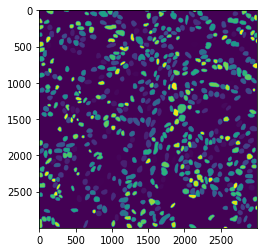

In [12]:



plt.imshow(pred_mask)

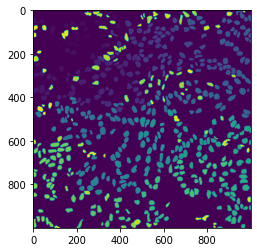

In [7]:
plt.imshow(gt_mask)

0.6425569188774436